<a href="https://colab.research.google.com/github/SairajNeelam/CoronaVirus-Tweet-Sentiment-Analysis/blob/main/CoronaVirus_Tweet_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Problem Statement***

> **We have to build a classification model to predict the sentiment of Covid-19 tweets**.





### **What is sentiment analysis?**
**Sentiment analysis, also known as opinion mining, or emotion AI, boils down to one thing:**

> **It’s the process of analyzing online pieces of writing to determine the emotional tone they carry, whether they’re positive, negative, or neutral.**

>**In simple words, sentiment analysis helps to find the author’s attitude towards a topic. Sentiment analysis tools categorize pieces of writing as positive, neutral, or negative**.

### **Why sentiment analysis is important?**

1. **Sentiment analysis is important because emotions and attitudes towards a topic can become actionable pieces of information useful in numerous areas of business and research.**
2. **Text analytics and opinion mining find numerous applications in e-commerce, marketing, advertising, politics, market research and any other research, which is very helpful for businesses.**
3. **It saves time and effort. Assessing the tone they carry manually is doable, but takes ages.**

### **Approach for the problem:**

1. **Data Review**
2. **Text Pre-processing**
3. **Text Parsing and Exploratory Data Analysis**
4. **Text Representation and Feature Engineering**
5. **Modeling or Pattern Mining**
6. **Evaluation**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re # for regular expressions
# import pandas as pd 
# pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

## ***Data Review***

In [3]:
working_dir_path = '/content/drive/MyDrive/AlmaBetter/Capstone Project/Datasets/CoronaVirus Tweet Sentiment Analysis/Coronavirus Tweets.csv'
df = pd.read_csv(working_dir_path, encoding = 'latin')

In [4]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
df.shape

(41157, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


> **We see that Location feature has null values and TweetAt feature must be in datetime format**

In [7]:
#defined a function to check Null/missing values in a dataframe

def check_Null(df):
    #Percentage of NAN Values 
    nan_df = [(col, df[col].isna().mean()*100) for col in df ]
    nan_df = pd.DataFrame(nan_df, columns=["column_name", "percentage"])

    #features with null values
    nan_df = nan_df[nan_df.percentage !=0]
    nan_df.sort_values("percentage", ascending=False)
    
    return nan_df

In [8]:
print("Missing Value Features : \n")
print(check_Null(df),"\n")

Missing Value Features : 

  column_name  percentage
2    Location   20.871298 



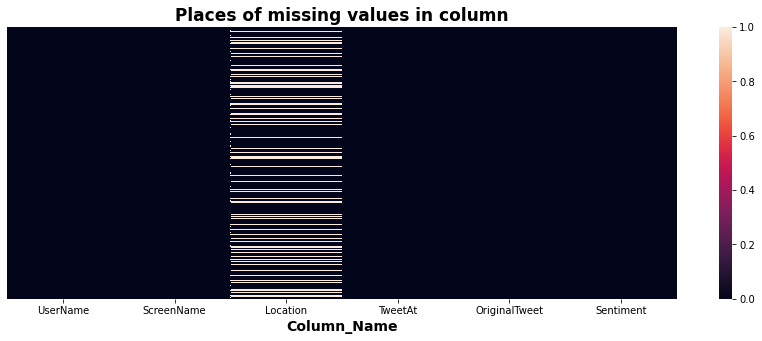

In [11]:
plt.figure(figsize=(15, 5))
sns.heatmap(df.isnull(), cbar=True, yticklabels=False)
plt.xlabel("Column_Name", size=14, weight="bold")
plt.title("Places of missing values in column",fontweight="bold",size=17)
plt.show()

> **We see that 20.87% of values from Location feature is missing**

> **Now let's see how many unique values are there in each feature**

In [12]:
#function def for displaying unique values for all features of dataframe 
def uniqueValuesForDf(df):
  unique_values = [(col , df[col].unique(),len(df[col].unique())) for col in df]
  unique_values = pd.DataFrame(unique_values, columns=["column_name", "Unique Values","Count of Unique values"])
  unique_values.sort_values(by=['Count of Unique values'])
  return unique_values

In [14]:
unique_values = uniqueValuesForDf(df)
unique_values

,column_name,Unique Values,Count of Unique values
0,UserName,"[3799, 3800, 3801, 3802, 3803, 3804, 3805, 380...",41157
1,ScreenName,"[48751, 48752, 48753, 48754, 48755, 48756, 487...",41157
2,Location,"[London, UK, Vagabonds, nan, ÃT: 36.319708,-8...",12221
3,TweetAt,"[16-03-2020, 17-03-2020, 18-03-2020, 19-03-202...",30
4,OriginalTweet,[@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/...,41157
5,Sentiment,"[Neutral, Positive, Extremely Negative, Negati...",5


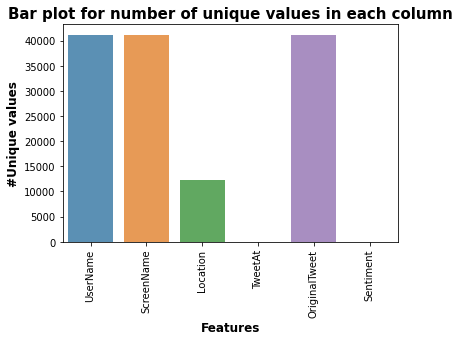

In [16]:
sns.barplot(x=unique_values['column_name'], y=unique_values['Count of Unique values'], alpha=0.8)
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

> **What we can tell is by looking at it is that the tweets collected are for short duration of time as only 30 unique values are there in the TweetAt feature, so let us explore later into it to get exact timeframe from which the tweets were collected**

> **Secondly, the tweets are categorized into 5 unique classes of sentiments**

> **Also, just by looking into Location feature we can see that we have some problems in it, as we can see some numerics in Location feature**

## ***Data Pre-processing***

In [17]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [18]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


### **Feature ▶ TweetAt**

In [23]:
df['TweetAt'].value_counts()

20-03-2020    3448
19-03-2020    3215
25-03-2020    2979
18-03-2020    2742
21-03-2020    2653
22-03-2020    2114
23-03-2020    2062
17-03-2020    1977
08-04-2020    1881
07-04-2020    1843
06-04-2020    1742
24-03-2020    1480
09-04-2020    1471
13-04-2020    1428
26-03-2020    1277
05-04-2020    1131
10-04-2020    1005
02-04-2020     954
11-04-2020     909
03-04-2020     810
12-04-2020     803
04-04-2020     767
16-03-2020     656
01-04-2020     630
27-03-2020     345
31-03-2020     316
14-04-2020     284
29-03-2020     125
30-03-2020      87
28-03-2020      23
Name: TweetAt, dtype: int64

In [24]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'], format='%d-%m-%Y')

In [26]:
df['TweetAt'].head()

0   2020-03-16
1   2020-03-16
2   2020-03-16
3   2020-03-16
4   2020-03-16
Name: TweetAt, dtype: datetime64[ns]

In [27]:
print(pd.DatetimeIndex(df['TweetAt']).year.value_counts(),"\n")
print('='*50)
print(pd.DatetimeIndex(df['TweetAt']).month.value_counts())

2020    41157
Name: TweetAt, dtype: int64 

3    25499
4    15658
Name: TweetAt, dtype: int64


> **So, the tweets are for the year 2020 and for only 2 months of March and April**

### **Feature ▶ OriginalTweet**

**For text data we need to do a bit different pre-processing:**

* **Tokenization**
* **Stop Words Removal**
* **Stemming/Lemmatization** 